In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [34]:
class VanDerPolPINN(nn.Module):
    def __init__(self):
        super(VanDerPolPINN, self).__init__()  
        self.net = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, t, y, v):
        x = torch.cat([t, y, v], dim=1)
        dvdt = self.net(x)
        return dvdt

In [35]:
def compute_pinn_loss(model, t, mu):
    t.requires_grad_(True)
    y = torch.randn_like(t, requires_grad=True) * 2  # y is dy/dt
    v = torch.randn_like(t, requires_grad=True) * 2  # v is dy/dt
    # Forward pass to get dvdt (d²y/dt²)
    dvdt = model(t, y, v)
    # Physics loss: Van der Pol equation
    # dvdt should equal μ(1-y²)v - y
    physics_pred = mu * (1 - y**2) * v - y
    physics_loss = torch.mean((dvdt - physics_pred)**2)
    
    return physics_loss

In [36]:
def train_pinn_vanderpol(mu, t_span, num_points=1000, epochs=20000):
    model = VanDerPolPINN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    t = torch.linspace(t_span[0], t_span[1], num_points).reshape(-1, 1)
    
    best_loss = float('inf')
    best_model_state = None
    
    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        
        loss = compute_pinn_loss(model, t, mu)
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model_state = model.state_dict().copy()
            
            torch.save(best_model_state, 'best_pinn_model.pth')
            print(f'Epoch {epoch+1}: New best loss: {best_loss:.6f}')
        
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Current Loss: {loss.item():.6f}, Best Loss: {best_loss:.6f}')
    
    # Load the best model state
    model.load_state_dict(torch.load('best_pinn_model.pth'))
    print(f'Training completed. Best loss achieved: {best_loss:.6f}')
    
    return model

In [37]:
def test_and_plot_comparison(original_model, pinn_model, t_values, mu):
    # Generate test data using solve_ivp like in your original code
    def van_der_pol(t, y, mu):
        dydt = [y[1], mu * (1 - y[0]**2) * y[1] - y[0]]
        return dydt
    
    initial_conditions = [2.0, 0.0]
    t_span = (t_values[0], t_values[-1])
    
    sol = solve_ivp(van_der_pol, t_span, initial_conditions, args=(mu,), t_eval=t_values)
    
    y_test = sol.y[0]
    v_test = sol.y[1]
    dvdt_test_true = mu * (1 - y_test**2) * v_test - y_test
    
    X_test = np.column_stack((t_values, y_test, v_test))
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    
    with torch.no_grad():
        original_pred = original_model(X_test_tensor).numpy()
        pinn_pred = pinn_model(
            X_test_tensor[:, 0:1],
            X_test_tensor[:, 1:2],
            X_test_tensor[:, 2:3]
        ).numpy()
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Original model predictions
    plt.subplot(2, 1, 1)
    plt.plot(t_values, dvdt_test_true, label='True dv/dt', color='blue', linewidth=2)
    plt.plot(t_values, original_pred, label='Original NN', color='red', linestyle='--', linewidth=2)
    plt.title('Original Neural Network Predictions vs True Values')
    plt.xlabel('Time (t)')
    plt.ylabel('dv/dt')
    plt.legend()
    plt.grid(True)
    
    # PINN predictions
    plt.subplot(2, 1, 2)
    plt.plot(t_values, dvdt_test_true, label='True dv/dt', color='blue', linewidth=2)
    plt.plot(t_values, pinn_pred, label='PINN', color='green', linestyle='--', linewidth=2)
    plt.title('PINN Predictions vs True Values')
    plt.xlabel('Time (t)')
    plt.ylabel('dv/dt')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [38]:
class VanDerPolNN(nn.Module):
    def __init__(self):
        super(VanDerPolNN, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 1: New best loss: 3852.455322
Epoch 4: New best loss: 3524.401855
Epoch 5: New best loss: 2764.862061
Epoch 42: New best loss: 2568.753662
Epoch 53: New best loss: 2358.727051
Epoch 79: New best loss: 2306.846924
Epoch 82: New best loss: 2022.244141
Epoch 100/20000, Current Loss: 2696.257568, Best Loss: 2022.244141
Epoch 147: New best loss: 2015.006836
Epoch 165: New best loss: 1919.688965
Epoch 175: New best loss: 1745.344727
Epoch 200/20000, Current Loss: 1944.480835, Best Loss: 1745.344727
Epoch 217: New best loss: 1629.031372
Epoch 220: New best loss: 1616.864624
Epoch 232: New best loss: 1506.025513
Epoch 299: New best loss: 1207.868652
Epoch 300/20000, Current Loss: 1452.929565, Best Loss: 1207.868652
Epoch 351: New best loss: 1132.722778
Epoch 389: New best loss: 1014.898071
Epoch 399: New best loss: 1004.627808
Epoch 400/20000, Current Loss: 1669.489990, Best Loss: 1004.627808
Epoch 416: New best loss: 834.439331
Epoch 426: New best loss: 828.761230
Epoch 432: New best lo

C:\Users\rishi\AppData\Local\Temp\ipykernel_8616\2837723688.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_pinn_model.pth'))
C:\

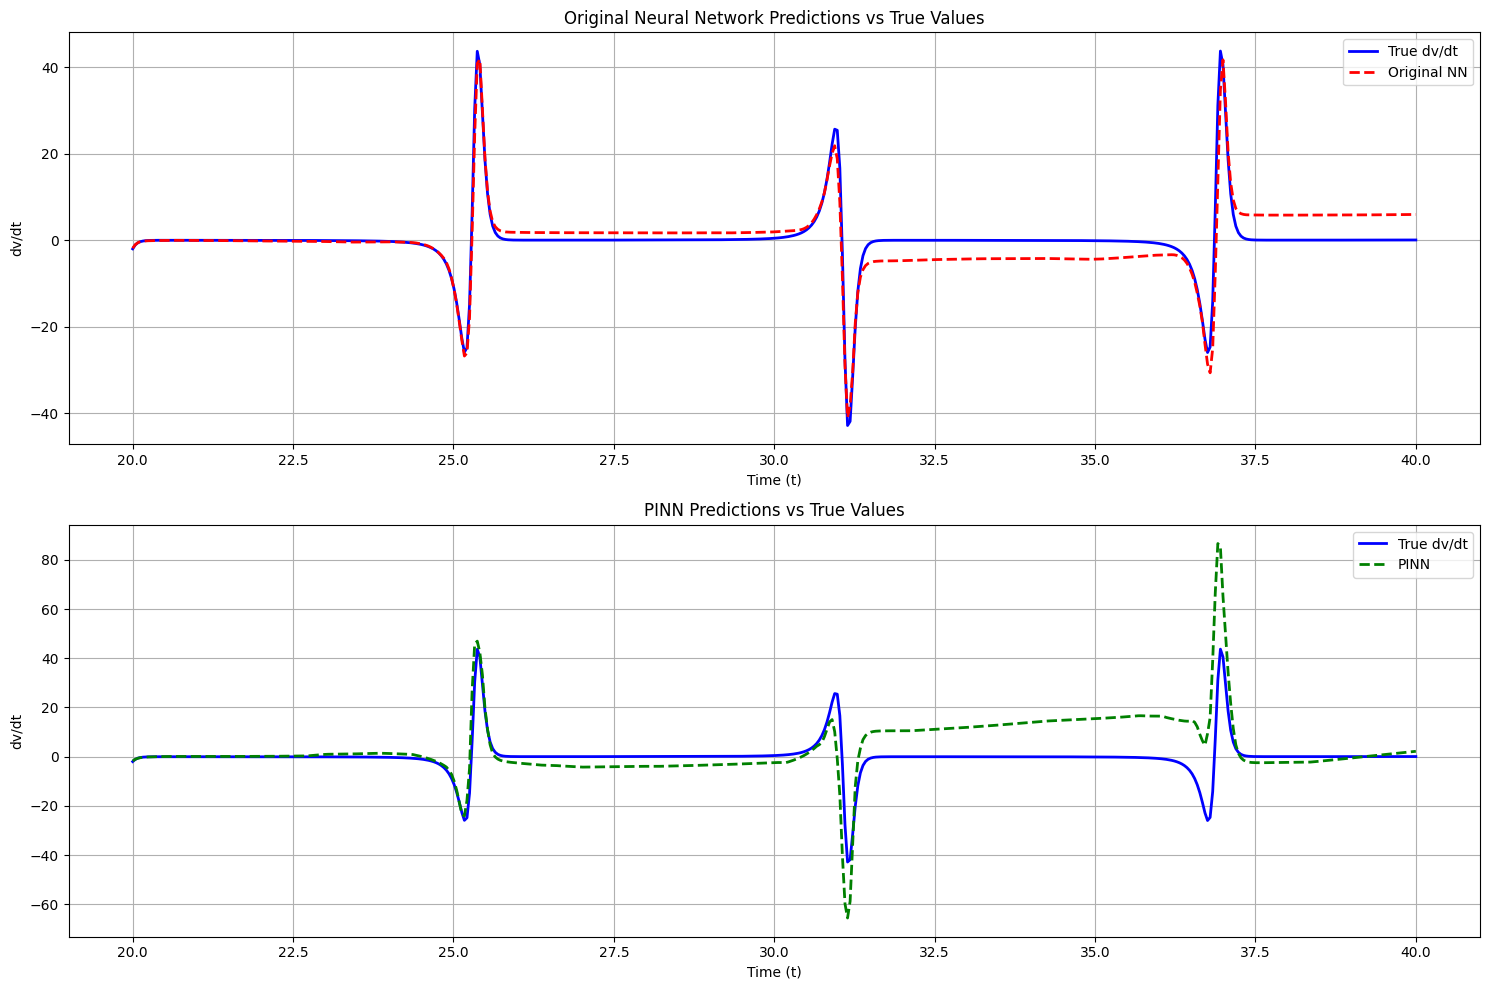

In [39]:
mu = 5
t_span = (0, 20)
t_values = np.linspace(20, 40, 500)

# Train PINN model
pinn_model = train_pinn_vanderpol(mu, t_span)

original_model = VanDerPolNN() 

original_model.load_state_dict(torch.load('vanderpol_model.pth'))

original_model.eval()
# Compare both models
test_and_plot_comparison(original_model, pinn_model, t_values, mu)